In [1]:
#!/usr/bin/env python

# WBGT_annual-maxima_warming-levels.ipynb

'''
    File name: WBGT_annual-maxima_warming-levels.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 04.03.2024
    Date last modified: 04.03.2024

    ############################################################## 
    Purpose:

    Read in WBGT data from CONUS404 control and PGW that were processed in:
    projects/2020_CONUS404/programs/CONUS404_preprocessor/GWBT_code/PyWBGT-1.0.0/Jupyter_notebooks/Calculate_WBGT_with_C404_data.py

    Calculate annual maxima for periods with similar global warming levels

    Show maps for different warming levels

'''

In [2]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import pickle
import time
import xarray as xr
from tqdm import tqdm
import matplotlib.gridspec as gridspec

### User imput section

In [3]:
conus404_ctr_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/GWBT/mon_max/'
time_c404_ctr = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2020, 12, 31, 23), freq='h')
years_ctr = np.unique(time_c404_ctr.year)
conus404_pgw_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData_PGW/GWBT/mon_max/'
time_c404_pgw = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2020, 12, 31, 23), freq='h')
years_pgw = np.unique(time_c404_pgw.year)
era5_dir = '/glade/campaign/mmm/c3we/ESTCP/ERA5/WBGT/'
time_era5 = pd.date_range(datetime.datetime(1950, 1, 1, 0), 
                              end=datetime.datetime(2019, 12, 31, 23), freq='h')

savedir = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/'

### Load the observed historic annual global temperature record

In [4]:
data = pd.read_csv('/glade/u/home/prein/papers/2024/2024_WBGT_Climate-Change/data/NASA_global-av_t2m/graph.txt', delimiter=r"\s+", header=0, skiprows=[0,1,2,4])

### LOAD GLOBAL AVERAGE T2M FROM LENS
##### this data was processed by Ming Ge

In [5]:
StartDay = datetime.datetime(1850, 1, 15,1)
StopDay = datetime.datetime(2101, 1, 15,0)
Time=pd.date_range(StartDay, end=StopDay, freq='M')
Time_years=pd.date_range(StartDay, end=StopDay, freq='Y')
years = np.unique(Time.year)

reference_period = [1950, 1980]

/glade/derecho/scratch/prein/tmp/ipykernel_49624/182532327.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  Time=pd.date_range(StartDay, end=StopDay, freq='M')
/glade/derecho/scratch/prein/tmp/ipykernel_49624/182532327.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  Time_years=pd.date_range(StartDay, end=StopDay, freq='Y')


In [6]:
lens2_t2m_dir = '/glade/campaign/mmm/c3we/mingge/DOD/LENS2/'
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_185001-197912.nc', mode='r')
TREFMNAV_hist = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_198001-201412.nc', mode='r')
TREFMNAV_cur = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_201501-210012.nc', mode='r')
TREFMNAV_fut = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()

ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_185001-197912.nc', mode='r')
TREFMXAV_hist = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_198001-201412.nc', mode='r')
TREFMXAV_cur = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_201501-210012.nc', mode='r')
TREFMXAV_fut = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()

In [7]:
TREFMNAV = np.append(TREFMNAV_hist, TREFMNAV_cur, axis=1)
TREFMNAV = np.append(TREFMNAV, TREFMNAV_fut, axis=1)
TREFMXAV = np.append(TREFMXAV_hist, TREFMXAV_cur, axis=1)
TREFMXAV = np.append(TREFMXAV, TREFMXAV_fut, axis=1)
lens2_t2m = (TREFMNAV + TREFMXAV) / 2.

lens2_t2m_y = np.mean(np.reshape(lens2_t2m, (lens2_t2m.shape[0], int(lens2_t2m.shape[1]/12), 12)), axis=2)

ref_t2m = np.mean(lens2_t2m_y[:,(years >= reference_period[0]) & (years <= reference_period[1])])
time_to_t2m = np.mean(lens2_t2m_y, axis=0) - ref_t2m

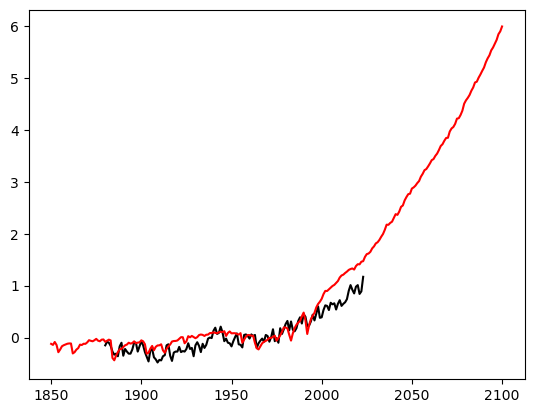

In [8]:
plt.plot(data['Year'], data['No_Smoothing'], c='k', label='NASA')
plt.plot(years, time_to_t2m, c='r', label='LENS2')

In [9]:
dc_hist = np.arange(0,1.5,0.1)
dc_pgw = np.arange(0,3.5,0.1)
dc = 0.5 # deg. C

ref_period = [1950,1979]

era5_ref = np.mean(data['No_Smoothing'][(data['Year'] >= ref_period[0]) & (data['Year'] <= ref_period[1])])
era5_warming = np.squeeze(np.array([data['No_Smoothing'][data['Year'] == yy] - era5_ref for yy in range(1980,2021,1)]))

lens2_ref = np.mean(time_to_t2m[(years >= ref_period[0]) & (years <= ref_period[1])])
lens2_warming = np.array([time_to_t2m[years == yy][0] - lens2_ref for yy in range(2022,2022+len(np.unique(time_c404_pgw.year)),1)])

pgw_warming = np.zeros((len(years_ctr))); pgw_warming[:] = np.nan
for yy in range(len(years_ctr)):
    lens_hist = (years <= years_ctr[yy] + 5) & (years >= years_ctr[yy] - 5)
    lens_fut = (years <= years_ctr[yy] + 40 + 5) & (years >= years_ctr[yy] + 40 - 5)
    pgw_warming[yy] = data['No_Smoothing'][years_ctr[yy] == data['Year']] + np.mean(time_to_t2m[lens_fut]) - np.mean(time_to_t2m[lens_hist])

/glade/derecho/scratch/prein/tmp/ipykernel_49624/2990714106.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pgw_warming[yy] = data['No_Smoothing'][years_ctr[yy] == data['Year']] + np.mean(time_to_t2m[lens_fut]) - np.mean(time_to_t2m[lens_hist])


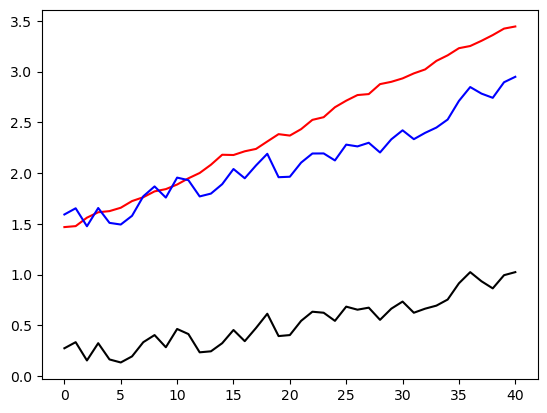

In [10]:
plt.plot(era5_warming, c='k')
plt.plot(lens2_warming, c='r')
plt.plot(pgw_warming, c='b')

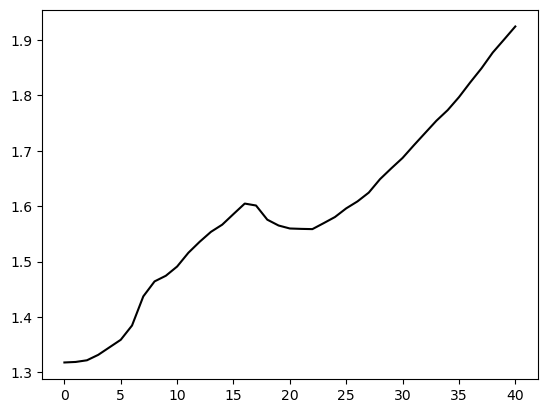

In [11]:
plt.plot(pgw_warming - era5_warming, c='k')

### Read in annual max. ERA5 WBGT

In [12]:
era_years = np.unique(time_era5.year)
conus_era5 = [100,1250,270,900]

# read ERA5 coordinates
ncid=Dataset('/glade/campaign/mmm/c3we/ESTCP/ERA5/WBGT/WBGT_ERA5_2008.nc', mode='r')
lon_e5 = np.array(np.squeeze(ncid.variables['longitude'][conus_era5[3]:conus_era5[1]]))
lat_e5 = np.array(np.squeeze(ncid.variables['latitude'][conus_era5[0]:conus_era5[2]]))
ncid.close()

era5_ymax_wbgt = savedir+"era5_annual-max_wbgt.npz"

if os.path.exists(era5_ymax_wbgt) == False:
    era5_wbgt = np.zeros((len(era_years), len(lat_e5), len(lon_e5))); era5_wbgt[:] = np.nan
    for yy in tqdm(range(len(era_years))):
        file = era5_dir + 'WBGT_ERA5_'+str(era_years[yy])+'.nc'
        ncid=Dataset(file, mode='r')
        era5_wbgt[yy,:,:] = np.max(np.array(np.squeeze(ncid.variables['WBGT'][:,conus_era5[0]:conus_era5[2],conus_era5[3]:conus_era5[1]])), axis=0)
        ncid.close()
else:
    data = np.load(era5_ymax_wbgt)
    era5_wbgt = data["era5_wbgt"]

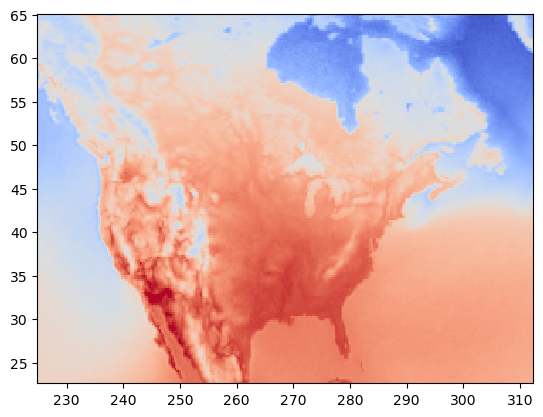

In [13]:
plt.pcolormesh(lon_e5, lat_e5, np.nanmean(era5_wbgt, axis=0)-273.15, cmap='coolwarm', vmin=10,vmax=37)

# Read CONUS404 CTR WBGT DATA

In [14]:
# read CONUS404 coordinates
ncid=Dataset('/glade/campaign/ncar/USGS_Water/CONUS404/wrfconstants_d01_1979-10-01_00:00:00.nc4', mode='r')
lon_conus = np.array(np.squeeze(ncid.variables['XLONG'][:]))
lat_conus = np.array(np.squeeze(ncid.variables['XLAT'][:]))
ncid.close()

In [15]:
c_ctr_years = np.unique(time_c404_ctr.year)

conus_ctr_wbgt = np.zeros((len(c_ctr_years), lon_conus.shape[0], lon_conus.shape[1])); conus_ctr_wbgt[:] = np.nan
for yy in tqdm(range(len(c_ctr_years))):
    data_year = np.zeros((12, lon_conus.shape[0], lon_conus.shape[1]))
    for mm in range(12):
        file = conus404_ctr_dir + 'max_GWBT_'+str(c_ctr_years[yy])+str(mm+1).zfill(2)+'_CONUS404.nc'
        ncid=Dataset(file, mode='r')
        data_year[mm,:,:] = np.squeeze(ncid.variables['GWBT'][:])
        ncid.close()
    conus_ctr_wbgt[yy,:,:] = np.max(data_year, axis=0)

100%|██████████| 41/41 [00:34<00:00,  1.19it/s]


/glade/derecho/scratch/prein/tmp/ipykernel_49624/72492939.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon_conus, lat_conus, np.nanmean(conus_ctr_wbgt, axis=0)-273.15, cmap='coolwarm', vmin=10,vmax=37)


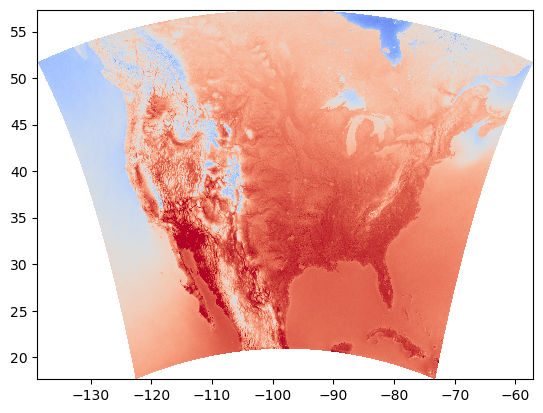

In [16]:
plt.pcolormesh(lon_conus, lat_conus, np.nanmean(conus_ctr_wbgt, axis=0)-273.15, cmap='coolwarm', vmin=10,vmax=37)

# Read CONUS404 PGW WBGT DATA

In [17]:
c_pgw_years = np.unique(time_c404_pgw.year)

conus_pgw_wbgt = np.zeros((len(c_pgw_years), lon_conus.shape[0], lon_conus.shape[1])); conus_pgw_wbgt[:] = np.nan
for yy in tqdm(range(len(c_pgw_years))):
    data_year = np.zeros((12, lon_conus.shape[0], lon_conus.shape[1]))
    for mm in range(12):
        file = conus404_pgw_dir + 'max_GWBT_'+str(c_pgw_years[yy])+str(mm+1).zfill(2)+'_CONUS404.nc'
        ncid=Dataset(file, mode='r')
        data_year[mm,:,:] = np.squeeze(ncid.variables['__xarray_dataarray_variable__'][:])
        ncid.close()
    conus_pgw_wbgt[yy,:,:] = np.max(data_year, axis=0)
    if np.isnan(np.max(conus_pgw_wbgt[yy,:,:])):
        stop()

100%|██████████| 41/41 [00:31<00:00,  1.31it/s]


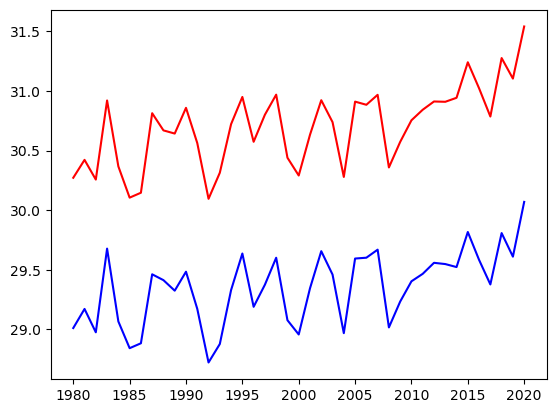

In [18]:
plt.plot(c_ctr_years, np.mean(conus_ctr_wbgt, axis=(1,2))-273.15, c='b')
plt.plot(c_pgw_years, np.mean(conus_pgw_wbgt, axis=(1,2))-273.15, c='r')

In [19]:
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.feature as cf
import cartopy.crs as ccrs
GEO_EM_D1 = '/glade/u/home/prein/projects/2020/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc'
ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT_M")
cart_proj = get_cartopy(HGT_M)
ncid.close()

In [20]:
from matplotlib import colors as c
wbgt_colros = ['#737373','#969696','#bdbdbd','#d9d9d9','#f0f0f0','#ffff99', '#ffcc00', '#ff9933', '#ff6666', '#ff0000', '#800000', '#cc3399','#990099', '#ff00ff']

foc_region = '' #'Yuma'
if foc_region != 'Yuma':
    ticks_color = np.array(range(24, 24+len(wbgt_colros), 1))
else:
    ticks_color = np.array(range(28, 28+len(wbgt_colros), 1))
cMap = c.ListedColormap(wbgt_colros)

In [21]:
# got WRF map projection
ncfile = Dataset("/glade/campaign/ncar/USGS_Water/CONUS404/wrfconstants_d01_1979-10-01_00:00:00.nc4")
slp = getvar(ncfile, "SNOALB")
cart_proj = get_cartopy(slp)

In [22]:
def coarsen(data,
            factor):
    data = np.reshape(data[:int(int(data.shape[0]/factor)*factor),
                           :int(int(data.shape[1]/factor)*factor)], 
                             (int(data.shape[0]/factor),
                             factor,
                             int(data.shape[1]/factor),
                             factor))
    return np.mean(data, axis = (1,3))

def coarsen3d(data,
            factor):
    data = np.reshape(data[:,:int(int(data.shape[1]/factor)*factor),
                             :int(int(data.shape[2]/factor)*factor)], 
                             (data.shape[0],
                              int(data.shape[1]/factor),
                             factor,
                             int(data.shape[2]/factor),
                             factor))
    return np.mean(data, axis = (2,4))
gc = 5

mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: annual-max-WBGT_change.jpg


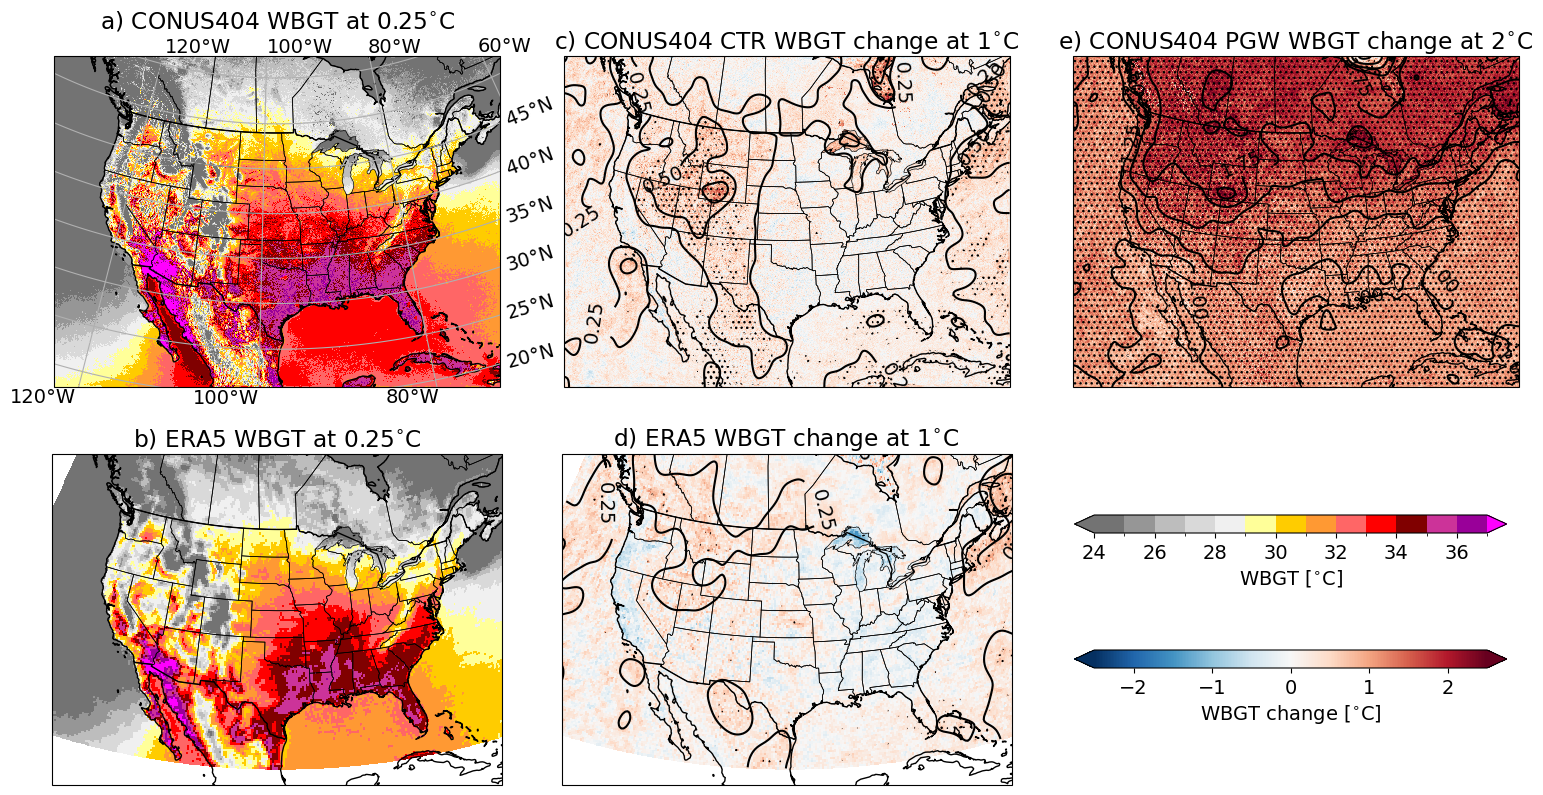

In [23]:
fig = plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 14})
gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.05, right=0.99,
           bottom=0.12, top=0.93,
           wspace=0.05, hspace=0.2)

# =========================
# 0.25 C warming
ax = plt.subplot(gs1[0,0], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 0.25
targ_years_ref = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title('a) CONUS404 WBGT at '+str(warming_tar)+'$^{\circ}$C')

cs = ax.pcolormesh(lon_conus, lat_conus, np.nanmean(conus_ctr_wbgt[targ_years_ref,:], axis=0)-273.15, 
                   cmap=cMap, transform=ccrs.PlateCarree(),
                   norm = mpl.colors.BoundaryNorm(ticks_color, ncolors=len(ticks_color)-1, clip=False))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.left_labels = False
gl.xlabel_style = {'rotation': 0}


# =========================
# 0.25 C warming ERA5
ax = plt.subplot(gs1[1,0], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 0.25
targ_years_ref = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title('b) ERA5 WBGT at '+str(warming_tar)+'$^{\circ}$C')

cs = ax.pcolormesh(lon_e5, lat_e5, np.nanmean(era5_wbgt[np.isin(era_years, c_ctr_years),:][targ_years_ref[:-1],:], axis=0)-273.15, 
                   cmap=cMap, transform=ccrs.PlateCarree(),
                   norm = mpl.colors.BoundaryNorm(ticks_color, ncolors=len(ticks_color)-1, clip=False))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
ax.set_extent((-124, -72.5, 21, 55), ccrs.PlateCarree())
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())

# Add a color bar
CbarAx = plt.axes([0.7, 0.4, 0.27, 0.02])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
cb.set_label('WBGT [$^{\circ}$C]', fontsize=14)

# =========================
# 1 C warming change
ax = plt.subplot(gs1[0,1], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 1
targ_years = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title('c) CONUS404 CTR WBGT change at '+str(warming_tar)+'$^{\circ}$C')

change_signal = np.nanmean(conus_ctr_wbgt[targ_years,:], axis=0) - \
                   np.nanmean(conus_ctr_wbgt[targ_years_ref,:], axis=0)
cs = ax.pcolormesh(lon_conus, lat_conus, 
                   change_signal, 
                   cmap='RdBu_r', vmin=-2.5,vmax=2.5, transform=ccrs.PlateCarree())

sig = scipy.stats.mannwhitneyu(coarsen3d(conus_ctr_wbgt[targ_years,:], gc), 
                             coarsen3d(conus_ctr_wbgt[targ_years_ref,:], gc), axis = 0)
# add significance layer
ax.contourf(
    coarsen(lon_conus, gc), coarsen(lat_conus, gc), 
    sig.pvalue < 0.05,
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=['...',''],
)

# show contour lines of smoothed field
CS = plt.contour(lon_conus, lat_conus,
                   scipy.ndimage.gaussian_filter(change_signal, 20),
                   levels = (0.25,0.5,0.75,1,1.25,1.5,1.75,2), transform=ccrs.PlateCarree(), colors='black')
ax.clabel(CS, inline=1, fontsize=14)

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())


# =========================
# 1 C warming change ERA5
ax = plt.subplot(gs1[1,1], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 1
targ_years = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title('d) ERA5 WBGT change at '+str(warming_tar)+'$^{\circ}$C')

change_signal = np.nanmean(era5_wbgt[np.isin(era_years, c_ctr_years),:][targ_years[:-1],:], axis=0) - \
                   np.nanmean(era5_wbgt[np.isin(era_years, c_ctr_years),:][targ_years_ref[:-1],:], axis=0)
cs = ax.pcolormesh(lon_e5, lat_e5, 
                   change_signal, 
                   cmap='RdBu_r', vmin=-2.5,vmax=2.5, transform=ccrs.PlateCarree())

sig = scipy.stats.mannwhitneyu(era5_wbgt[np.isin(era_years, c_ctr_years),:][targ_years[:-1],:], 
                             era5_wbgt[np.isin(era_years, c_ctr_years),:][targ_years_ref[:-1],:], axis = 0)
# add significance layer
ax.contourf(
    lon_e5, lat_e5, 
    sig.pvalue < 0.05,
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=['...',''],
)

# show contour lines of smoothed field
CS = plt.contour(lon_e5, lat_e5, 
                   scipy.ndimage.gaussian_filter(change_signal, 5),
                   levels = (0.25,0.5,0.75,1,1.25,1.5,1.75,2), transform=ccrs.PlateCarree(), colors='black')
ax.clabel(CS, inline=1, fontsize=14)

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
ax.set_extent((-124, -72.5, 21, 55), ccrs.PlateCarree())
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())

# Add a color bar
CbarAx = plt.axes([0.7, 0.25, 0.27, 0.02])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
cb.set_label('WBGT change [$^{\circ}$C]', fontsize=14)


# =========================
# 2 C warming change
ax = plt.subplot(gs1[0,2], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 2
targ_years = (pgw_warming[:len(years_pgw)] >= warming_tar - dc) & (pgw_warming[:len(years_pgw)] <= warming_tar + dc)
plt.title('e) CONUS404 PGW WBGT change at '+str(warming_tar)+'$^{\circ}$C')

change_signal = np.nanmean(conus_pgw_wbgt[targ_years,:], axis=0) - \
                   np.nanmean(conus_ctr_wbgt[targ_years_ref,:], axis=0)
cs = ax.pcolormesh(lon_conus, lat_conus, 
                   change_signal, 
                   cmap='RdBu_r', vmin=-2.5,vmax=2.5, transform=ccrs.PlateCarree())

sig = scipy.stats.mannwhitneyu(coarsen3d(conus_pgw_wbgt[targ_years,:], gc), 
                             coarsen3d(conus_ctr_wbgt[targ_years_ref,:], gc), axis = 0)
# add significance layer
ax.contourf(
    coarsen(lon_conus, gc), coarsen(lat_conus, gc), 
    sig.pvalue < 0.05,
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=['...',''],
)

# show contour lines of smoothed field
CS = plt.contour(lon_conus, lat_conus,
                   scipy.ndimage.gaussian_filter(change_signal, 20),
                   levels = (0.25,0.5,0.75,1,1.25,1.5,1.75,2), transform=ccrs.PlateCarree(), colors='black')
ax.clabel(CS, inline=1, fontsize=14)
ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())

sPlotFile=""
sPlotName= 'annual-max-WBGT_change.jpg'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, dpi=700)